In [1]:
from datetime import date
from io import BytesIO
from IPython import display

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

In [2]:
import model_card_toolkit as mctlib

2021-09-23 17:54:42.779689: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-23 17:54:42.779869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

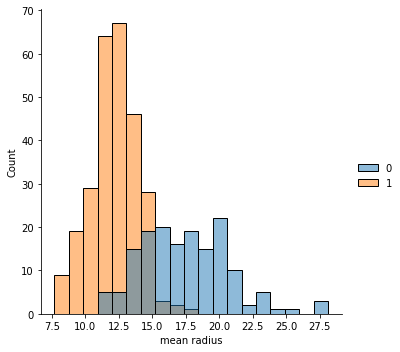

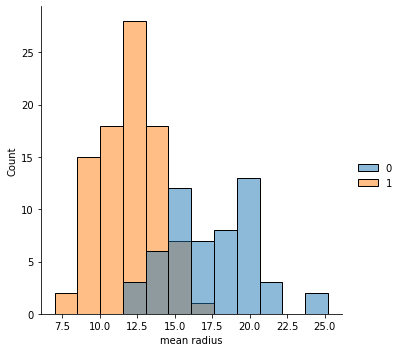

In [5]:
# Plot the mean radius feature for both the train and test sets

sns.displot(x=X_train['mean radius'], hue=y_train)
mean_radius_train = plot_to_str()

sns.displot(x=X_test['mean radius'], hue=y_test)
mean_radius_test = plot_to_str()

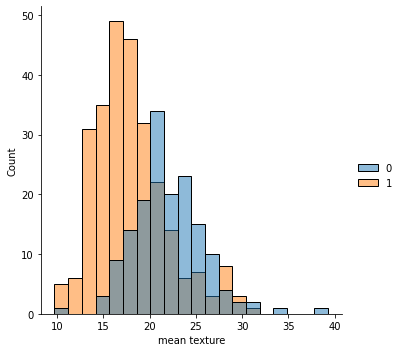

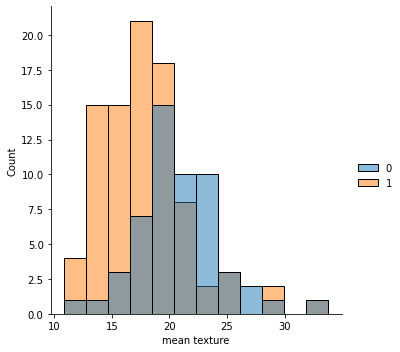

In [6]:
# Plot the mean texture feature for both the train and test sets

sns.displot(x=X_train['mean texture'], hue=y_train)
mean_texture_train = plot_to_str()

sns.displot(x=X_test['mean texture'], hue=y_test)
mean_texture_test = plot_to_str()

In [7]:
# Create a classifier and fit the training data

clf = GradientBoostingClassifier().fit(X_train, y_train)

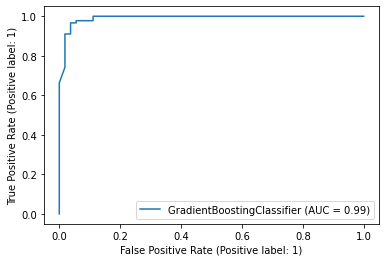

In [8]:
# Plot a ROC curve

plot_roc_curve(clf, X_test, y_test)
roc_curve = plot_to_str()

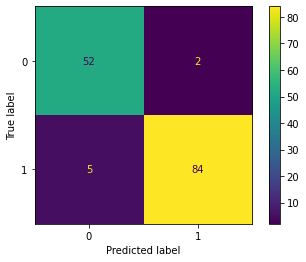

In [9]:
# Plot a confusion matrix

plot_confusion_matrix(clf, X_test, y_test)
confusion_matrix = plot_to_str()

In [10]:
mc = mctlib.ModelCard()
mct = mctlib.ModelCardToolkit(output_dir = "output/")
model_card = mct.scaffold_assets()

In [11]:
model_card.model_details.name = 'Breast Cancer Wisconsin (Diagnostic) Dataset'
model_card.model_details.overview = (
    'This model predicts whether breast cancer is benign or malignant based on '
    'image measurements.')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Model Cards Team', contact='model-cards@google.com', role="auditor")
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)'),
    mctlib.Reference(reference='https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf')
]
model_card.model_details.version.name = str(uuid.uuid4())
model_card.model_details.version.date = str(date.today())

model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Manual selection of image sections to digitize could create '
            'selection bias'),
    mitigation_strategy='Automate the selection process'
)]
model_card.considerations.limitations = [mctlib.Limitation(description='Breast cancer diagnosis')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Breast cancer diagnosis')]
model_card.considerations.users = [mctlib.User(description='Medical professionals'), mctlib.User(description='ML researchers')]

model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[0].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=mean_radius_train),
    mctlib.Graphic(image=mean_texture_train)
]
model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=mean_radius_test),
    mctlib.Graphic(image=mean_texture_test)
]

model_card.quantitative_analysis.performance_metrics.append(mctlib.PerformanceMetric())
model_card.quantitative_analysis.performance_metrics[0].type = "accuracy"
model_card.quantitative_analysis.performance_metrics[0].value = str((49 + 89) / (49 + 89 + 2 + 3))
model_card.quantitative_analysis.performance_metrics[0].slice = "training"
model_card.quantitative_analysis.performance_metrics[0].graphics.description = (
  'ROC curve and confusion matrix')
model_card.quantitative_analysis.performance_metrics[0].graphics.collection = [
    mctlib.Graphic(image=roc_curve),
    mctlib.Graphic(image=confusion_matrix)
]

model_card.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(type="feature importance", slice="training", description="top 5 features")
]

model_card.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(type="fairness parity metric", slice="training", segment="gender", description="TPR")
]

mct.update_model_card(model_card)

In [12]:
md = mct.export_format(template_path="output/template/md/default_template.md.jinja", output_file="model_card.md")

In [13]:
html = mct.export_format()

display.display(display.HTML(html))

Name,Value
"accuracy, training",0.965034965034965


## Prep test dataset

In [14]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

from FEATTests.SubgroupDifference import SubgroupDifference
from FEATTests.SubgroupMetricThreshold import SubgroupMetricThreshold

In [15]:
# Credit dataset
df = pd.read_csv("credit_reject.csv")
x = df.drop("reject", axis=1)
y = df["reject"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.8, random_state=32
)
estimator = RandomForestClassifier(n_estimators=10, max_features="sqrt")
# estimator = LogisticRegression()

# Apply one hot encoding to categorical columns (auto-detect object columns)
ens = ce.OneHotEncoder(use_cat_names=True)
x_train = ens.fit_transform(x_train)
x_test = ens.transform(x_test)

estimator.fit(x_train, y_train)

output = x_test.copy()
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]
# print(confusion_matrix(y_test, y_pred))

output = ens.inverse_transform(output)
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


df_importance = pd.DataFrame(
    {"features": x_test.columns, "value": estimator.feature_importances_}
)
df_importance = df_importance.sort_values(df_importance.columns[1], ascending=False)
train = ens.inverse_transform(x_train)
test = ens.inverse_transform(x_test)

/home/jason/miniconda3/envs/mct/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Run some FEAT Tests on it

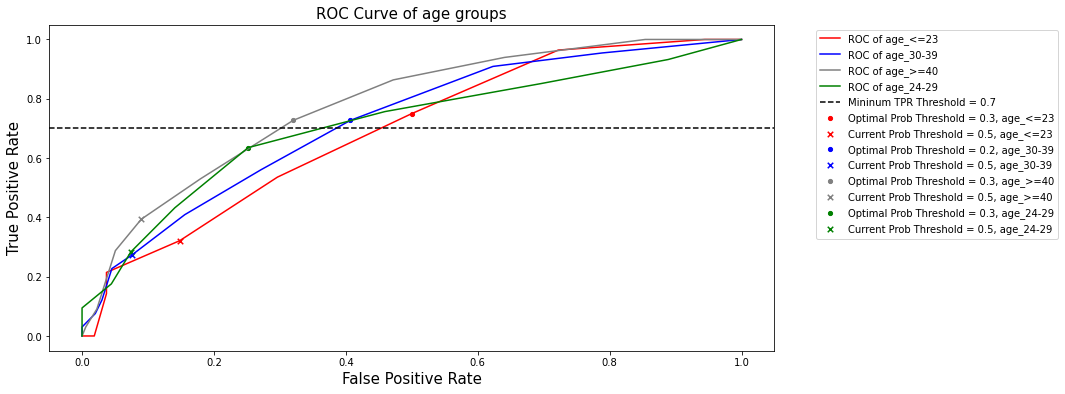

In [16]:
smt_test = SubgroupMetricThreshold(
    test_name="subgroup metric threshold",
    test_desc="",
    attr="age",
    metric="tpr",
    threshold=0.70,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

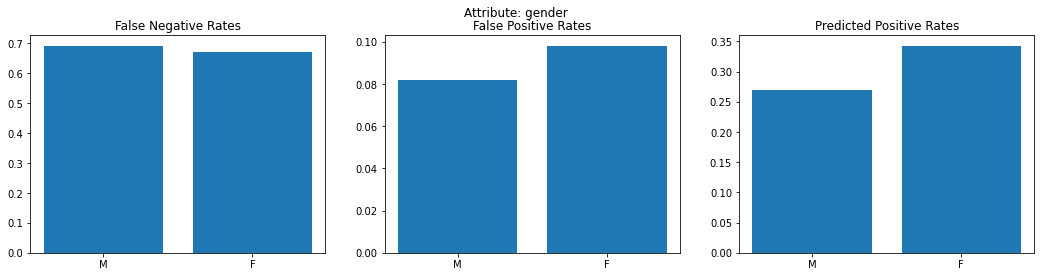

In [17]:
# SubgroupDifference Test
sgd_test = SubgroupDifference(
    test_name='subgroup diff',
    test_desc='my first subgroup difference test',
    attr='gender',
    metric='sr',
    method='ratio',
    threshold=1.5,
)
sgd_test.run(output)
sgd_test.plot()

## Nice representation of test objects

In [18]:
smt_test

SubgroupMetricThreshold(test_name='subgroup metric threshold', test_desc='', result=['<=23', '30-39', '>=40', '24-29'], passed=False, attr='age', metric='tpr', threshold=0.7, proba_thresholds=None)

In [19]:
sgd_test

SubgroupDifference(test_name='subgroup diff', test_desc='my first subgroup difference test', result={'gender_sr_max_ratio': 1.2697553583026628}, passed=True, attr='gender', metric='sr', method='ratio', threshold=1.5)

In [ ]:
sgd_test.__dict__

## Convert test objects to a model-card-compatible format

In [ ]:
# init model card test object
mc_test = mctlib.Test()

# assign sgd_test to it
mc_test.read_feat_test(sgd_test)
mc_test

In [22]:
# init model card test objects
mc_smt_test = mctlib.Test()
mc_sgd_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_feat_test(smt_test)
mc_sgd_test.read_feat_test(sgd_test)

## Add test to model card and update it

In [23]:
model_card.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(type='Model performance across subgroups should be within a defined threshold', tests=[mc_smt_test]),
    mctlib.FairnessReport(type='Model performance across subgroups should be similar', tests=[mc_sgd_test])
]

mct.update_model_card(model_card)

## Display HTML

In [24]:
html2 = mct.export_format(template_path="output/template/html/mod_template.html.jinja", output_file="model_card.html")

display.display(display.HTML(html2))